## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [28]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Basic imports:

In [29]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Define parameters

In [30]:
# SSAM vector field resolution:
um_per_pixel = 3

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [31]:

if dataset == 0:

    spot_df_raw = pd.read_csv('/dh-projects/ag-ishaque/analysis/tiesmeys/data/zenodo/MERFISH/raw_data/merfish_barcodes_example.csv', usecols=['Gene_name', 'Centroid_X', 'Centroid_Y', 'Centroid_Z'],)
    spot_df_raw.columns = ['gene','x','y','z']



    # Remove 'blank' genes:
    spot_df_raw = spot_df_raw[~spot_df_raw.gene.str.contains('Blank')][::1]

    spot_df_raw['gene']=spot_df_raw['gene'].astype('category')

    # spot_df = spot_df_raw.copy()
    genes = sorted(spot_df_raw.gene.unique())


spot_df_raw.x-=spot_df_raw.x.min()
spot_df_raw.y-=spot_df_raw.y.min()

spot_df_raw.x/=um_per_pixel
spot_df_raw.y/=um_per_pixel




In [32]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(spot_df_raw,min_distance=5,threshold_fraction=0.3,density_weight=0.05)
# _=ovrlp.assign_xy(spot_df_raw)
roi_df

x    y  divergence
4263  586  508    6.352946
2179  298  585    5.209310
953   113    0    4.658484
25      0  367    4.380733
4028  557  118    4.275596
...   ...  ...         ...
2655  375  391    1.906747
2707  383  294    1.906691
298    33  109    1.906522
2174  297   71    1.906272
236    25  115    1.906028

[4411 rows x 3 columns]

#### Load snRNAseq data for cell typing:

In [33]:
import gzip

scrna_genes = []

with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_genes.tsv.gz "), "rt") as f:
    for line in f:
        ensid, gene = line.rstrip().split('\t')
        # Correct gene name
        if gene == '4732456N10Rik':
            gene = "Krt90"
        scrna_genes.append(gene)

scrna_barcodes = []
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_barcodes.tsv.gz"), "rt") as f:
    for line in f:
        scrna_barcodes.append(line.rstrip())

from scipy.io import mmread
with gzip.open(os.path.join(file_root,"../../data/zenodo/MERFISH/raw_data/GSE113576_matrix.mtx.gz")) as f:
    scrna_expmat = mmread(f)

import scanpy as sc
import anndata

adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})
adata_scrna.obs.index = adata_scrna.obs.index.astype(int)

adata_scrna.X = np.array(np.nan_to_num(adata_scrna.X).todense()).squeeze()

scrna_cluster_dic = {}
scrna_cluster_dic2 = {}

# Downloaded from supp. material of Moffit et al, table S1
# This file contains cluster metadata
table_s1_df = pd.read_csv(os.path.join(file_root, 
            "../../data/zenodo/MERFISH/raw_data/aau5324_moffitt_table-s1.csv"), on_bad_lines='skip', )
table_s1_df = table_s1_df.fillna('')
adata_scrna.obs['cluster_1'] = ''
adata_scrna.obs['cluster_2'] = ''

n=0

for i, (bc, _, _, c1, c2, c3) in table_s1_df.iterrows():
    if c2 == '' and c3 == '':
        c2 = c1 # Ambiguous and Unstable
    elif c2 == '':
        c2 = c1 + ' (' + c3 + ')'
        
    adata_scrna.obs.loc[n,'cluster_1'] = c1
    adata_scrna.obs.loc[n,'cluster_2'] = c2
    
    scrna_cluster_dic[bc] = c1
    scrna_cluster_dic2[bc] = c2

    n+=1

celltypes = sorted(adata_scrna.obs.cluster_1.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_scrna.X[adata_scrna.obs.cluster_1==celltype]
    subset = pd.Series(np.nan_to_num(subset).mean(0),
                       index=adata_scrna.var.gene.values)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)

signatures = signatures**0.5

/tmp/ipykernel_1544790/91754860.py:25: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_scrna = anndata.AnnData(X=scrna_expmat.T, obs={'barcode': scrna_barcodes}, var={'gene': scrna_genes})


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Plotting case 0
Plotting case 10
Plotting case 33
Plotting case 66
Plotting case 100
Plotting case 150


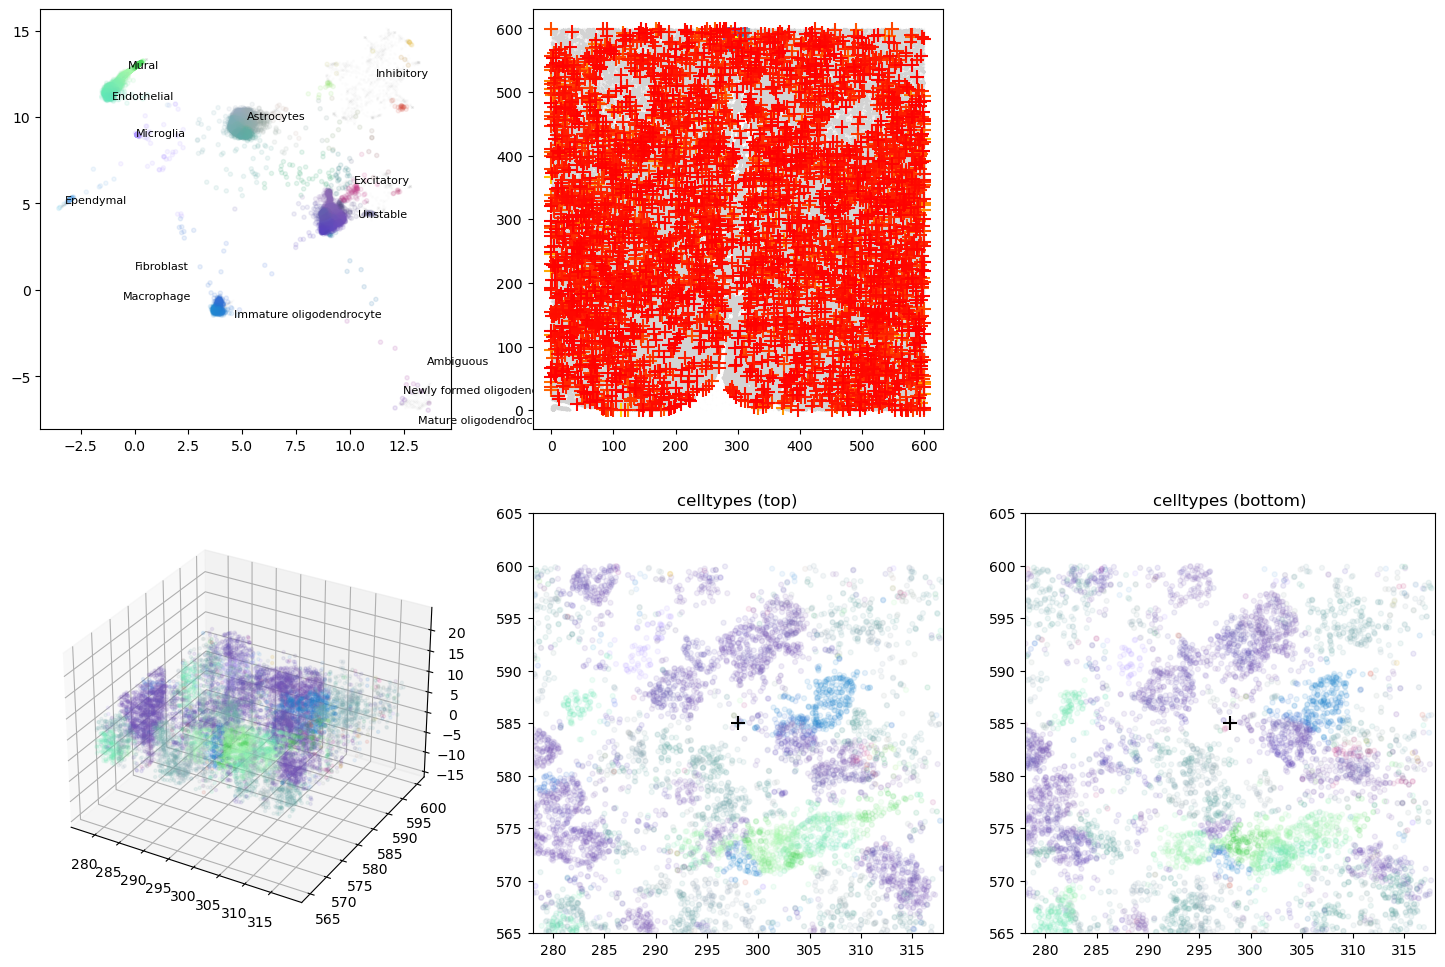

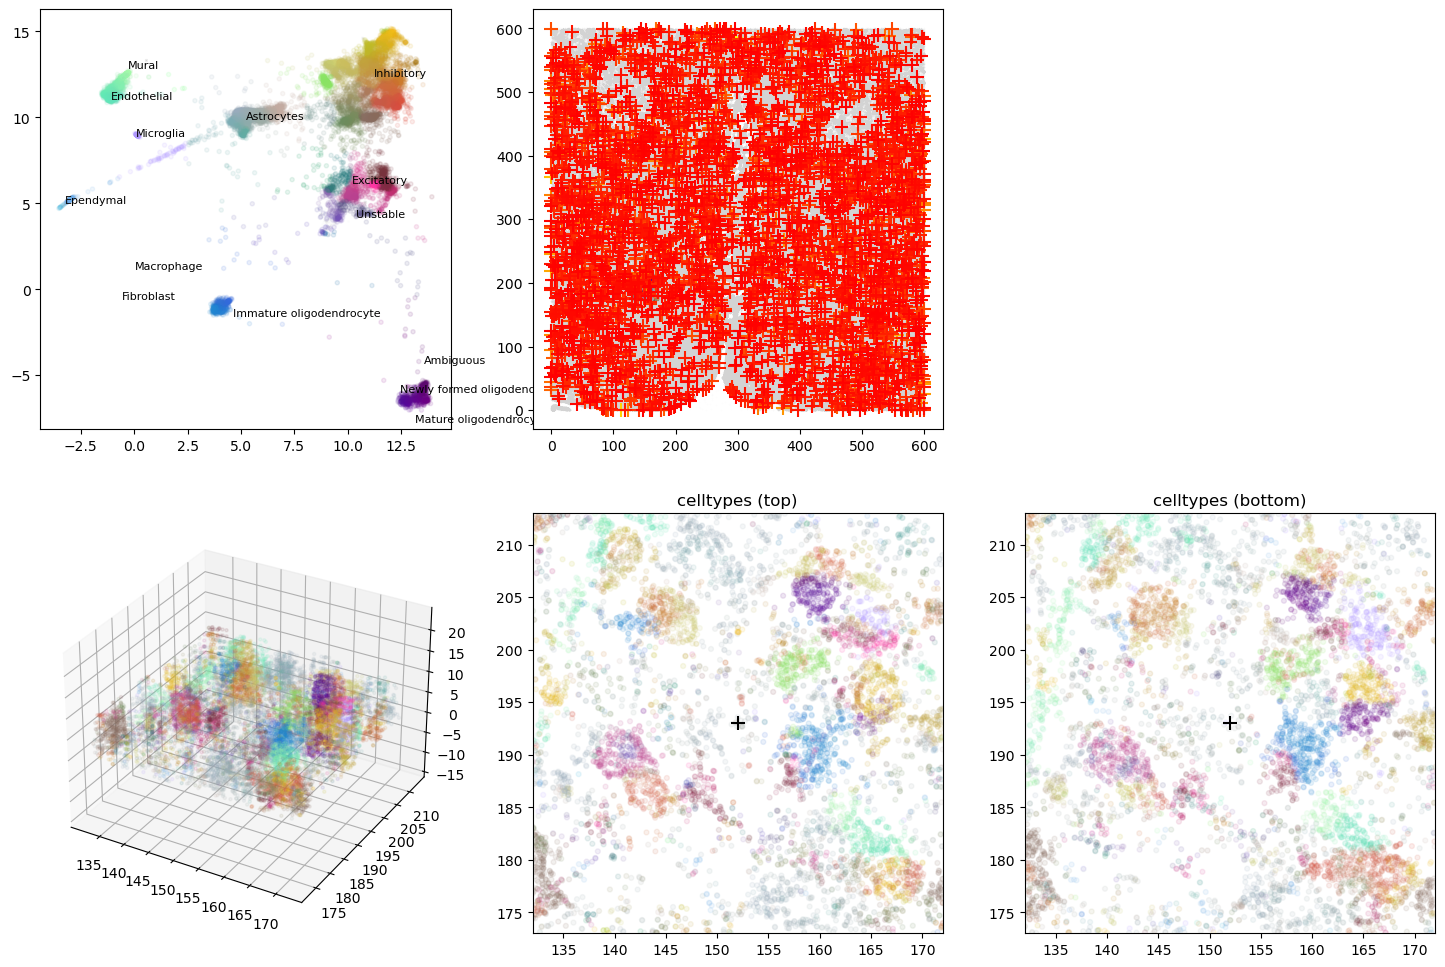

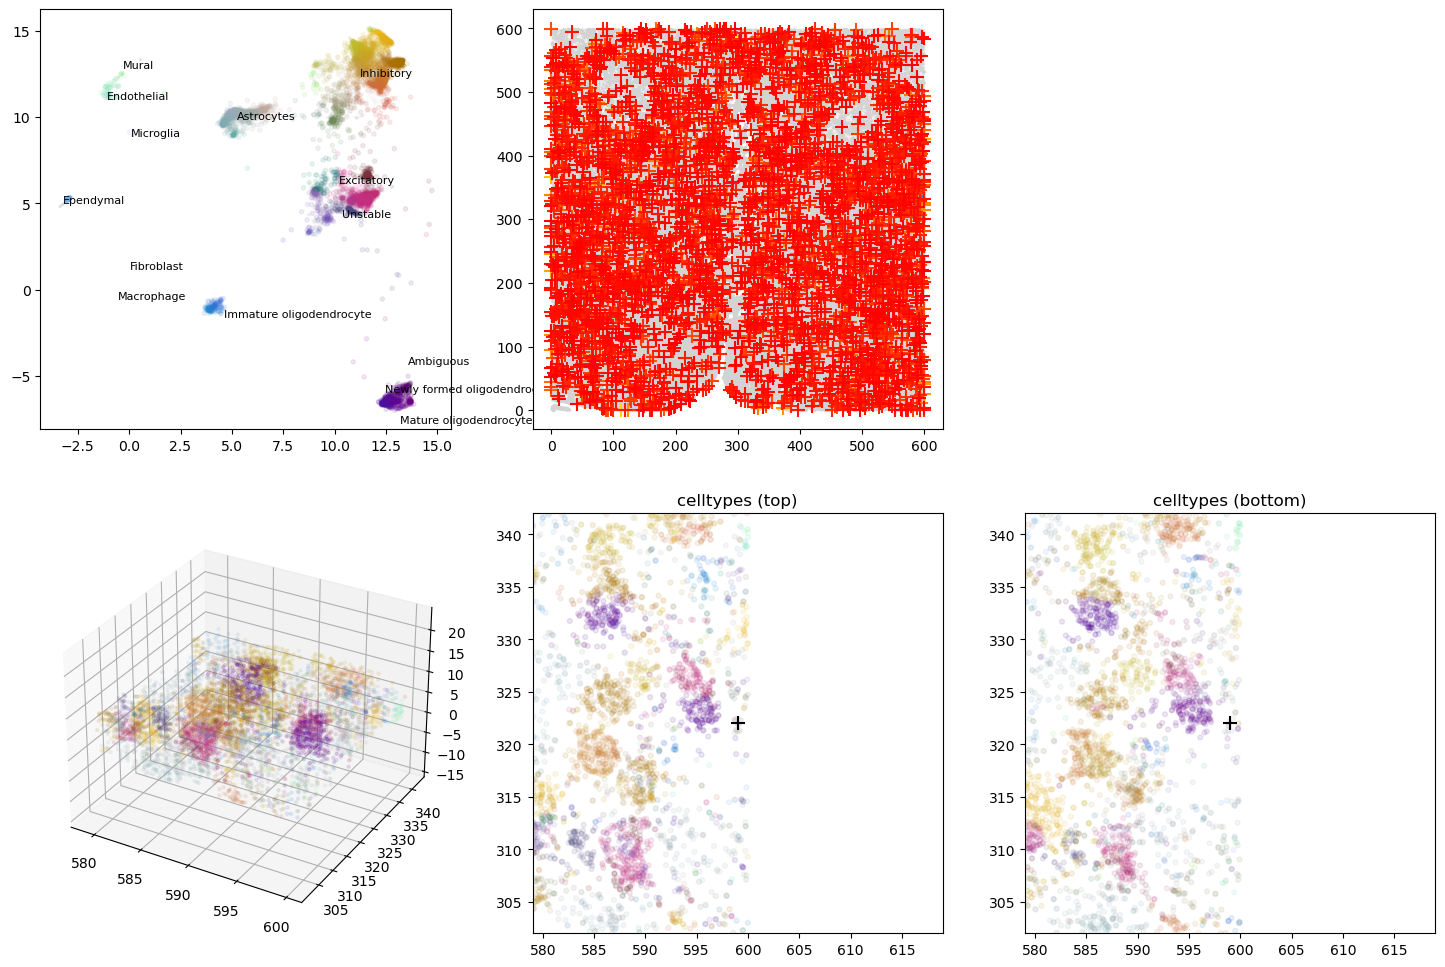

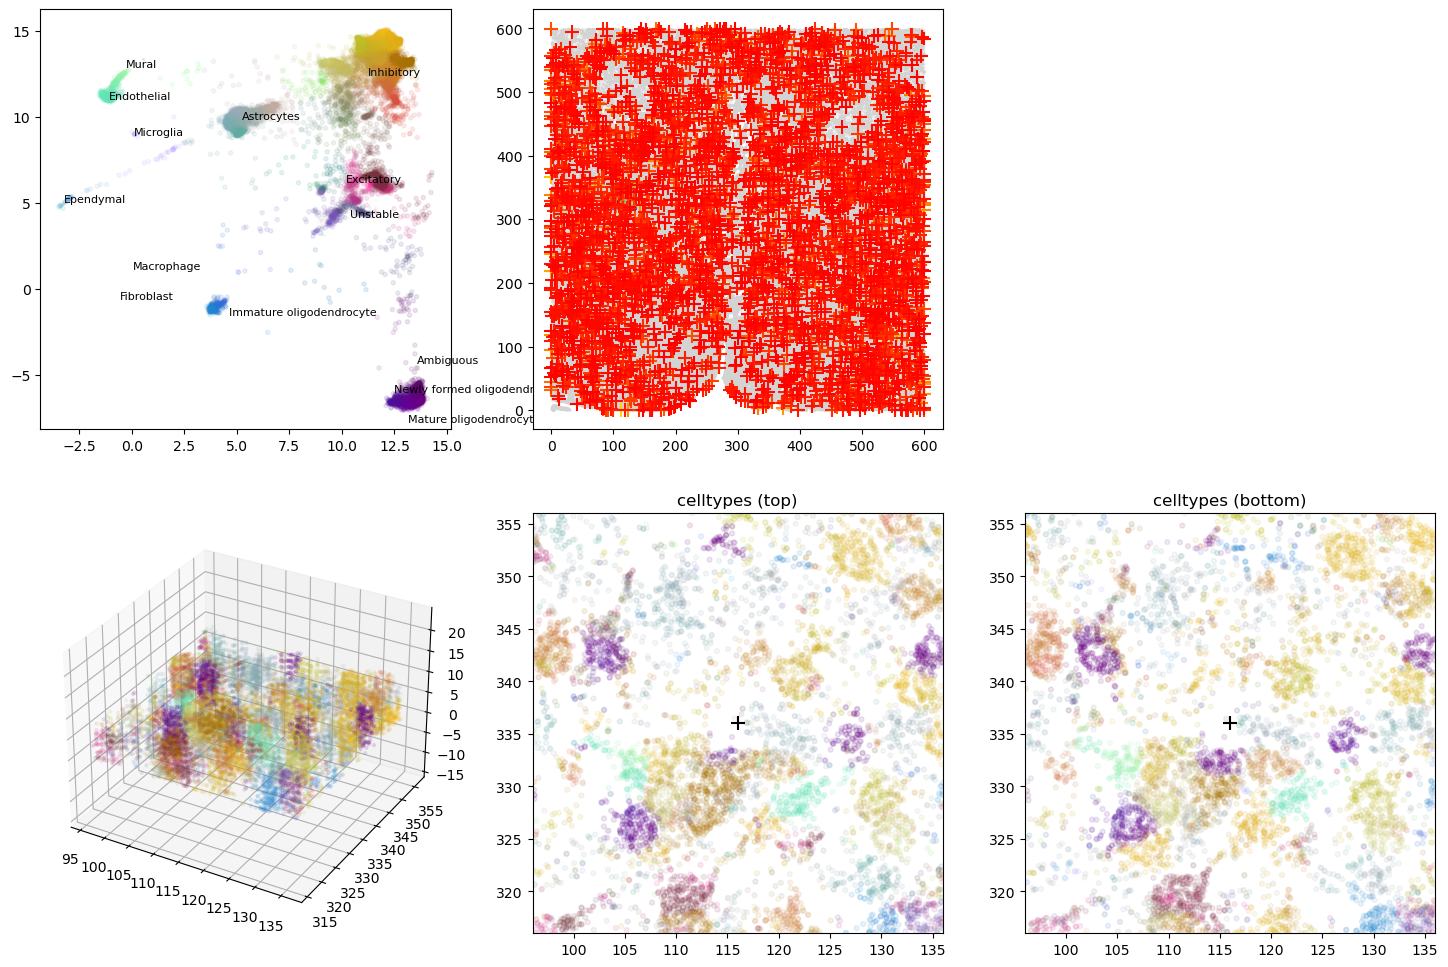

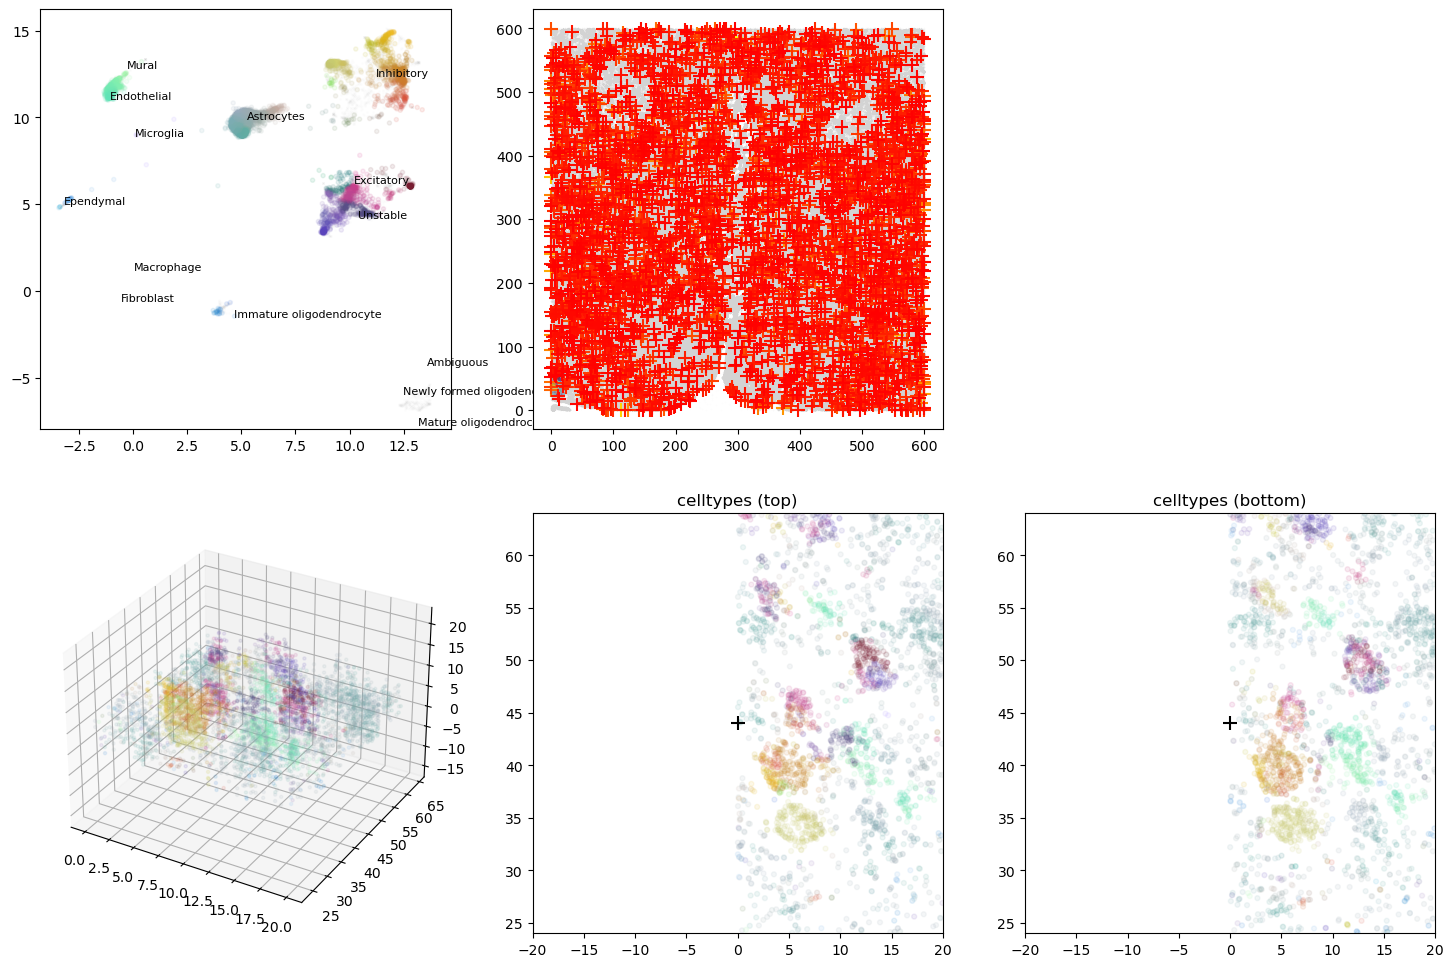

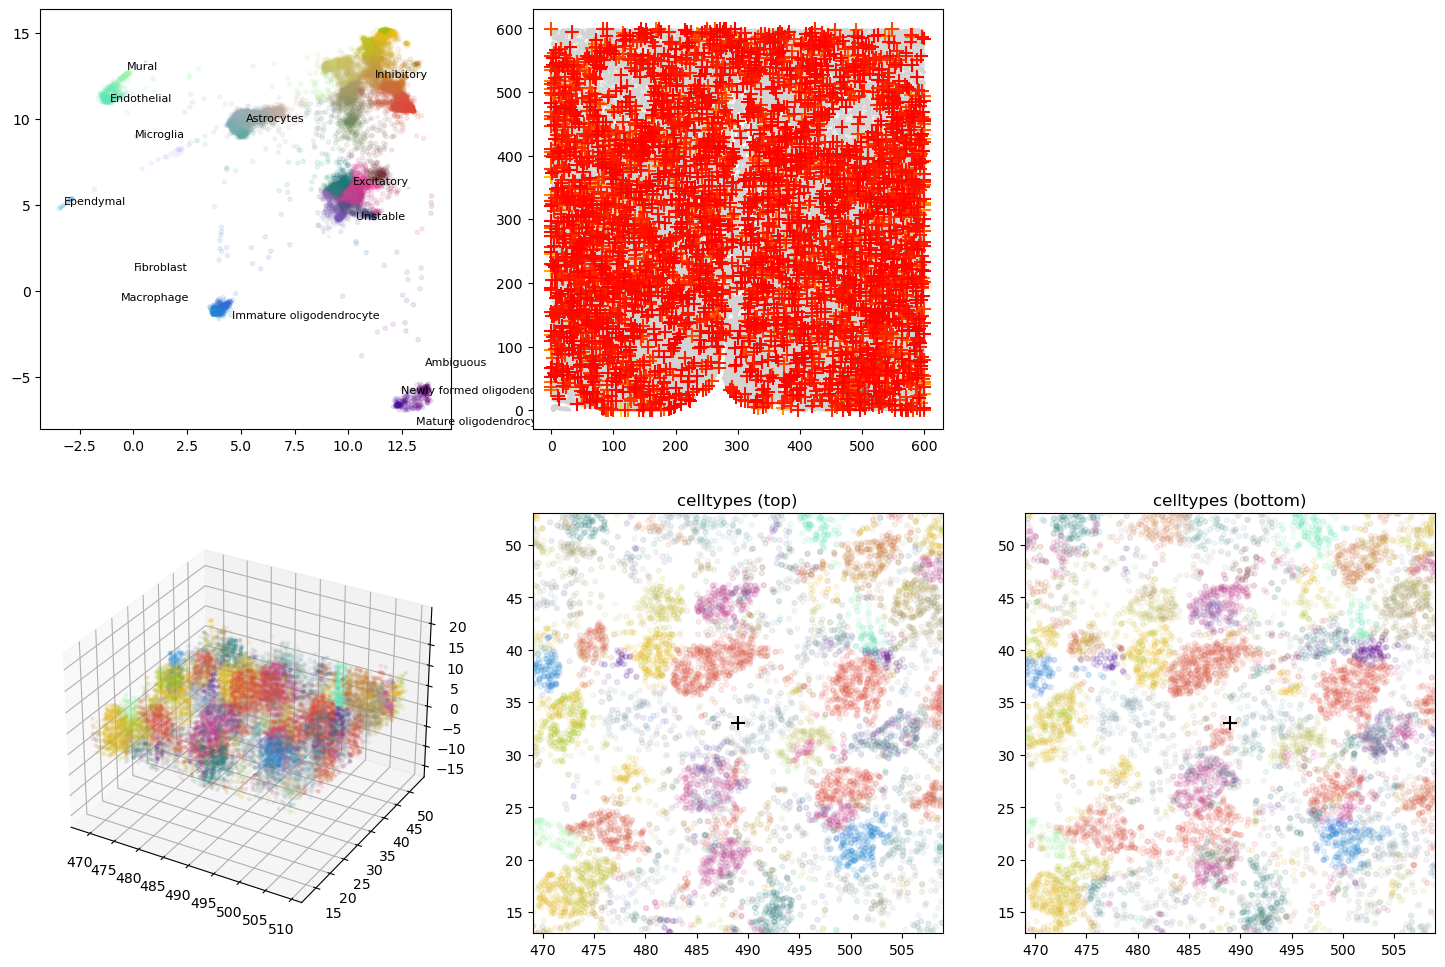

In [34]:

ovrlp.visualize_rois(spot_df_raw,roi_df.iloc[1:], signature_matrix=signatures,
                     celltyping_min_expression=5,
                     n_cases=[0,10,33,66,100,150],plot_window_size=20)

In [14]:

expressions_top = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z>spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes,)

expressions_bottom = ovrlp.get_expression_vectors_at_rois(df = spot_df_raw[spot_df_raw.z<spot_df_raw.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

                                        

In [15]:
celltype_labels_top = ovrlp.determine_celltype_class_assignments(expressions_top,signatures)
celltype_labels_bottom = ovrlp.determine_celltype_class_assignments(expressions_bottom,signatures)

In [16]:
# plt.figure(figsize=(7,14))

# plt.imshow(signatures,aspect='auto',interpolation='none')
# plt.xticks(np.arange(len(celltypes)),celltypes,rotation=90)
# plt.yticks(np.arange(len(genes)),genes)
# ''

marker_classes = pd.Series(np.argmax(signatures.to_numpy(),axis=1),index=genes)


(250.0, 290.0)

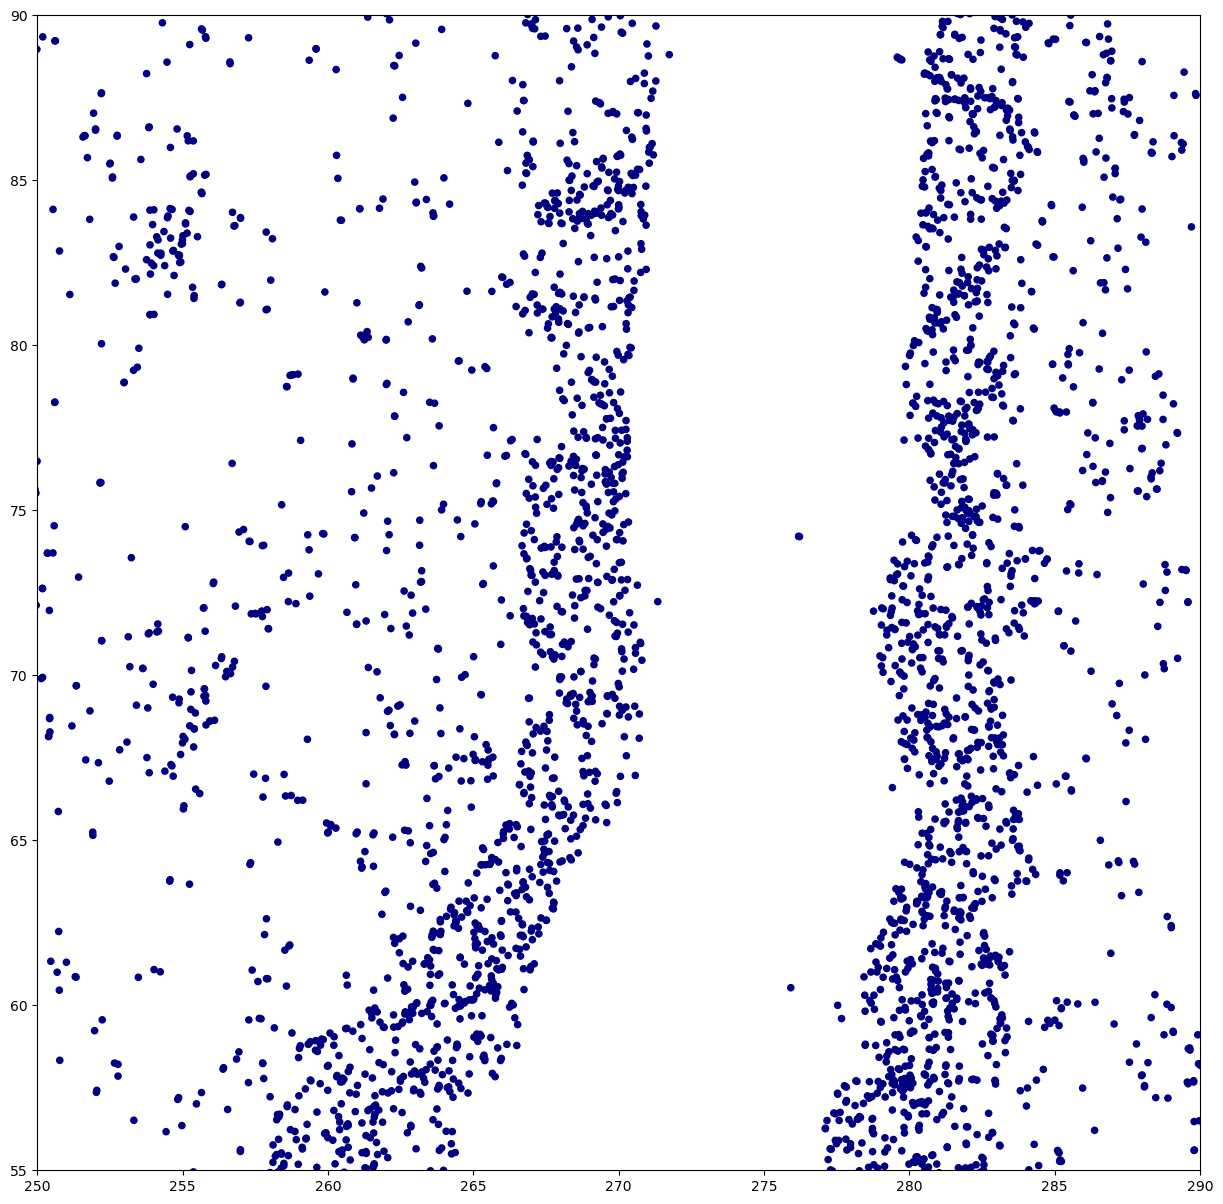

In [17]:
# # colors = (celltype_labels_bottom == (np.where(signatures.columns == 'Ependymal')[0][0]))-2*(celltype_labels_top == (np.where(signatures.columns == 'Astrocytes')[0][0]))
# colors = (np.where(signatures.columns == 'Endothelial')[0][0])

# # plt.scatter(roi_df.x,roi_df.y,c=colors,cmap='jet')
# colors

ependymal_markers = [g for g in genes if g in marker_classes[marker_classes==np.where(signatures.columns == 'Ependymal')[0][0]].index]
mask = spot_df_raw.gene.isin(ependymal_markers)

plt.figure(figsize=(15,15))
plt.scatter(spot_df_raw.x[mask],spot_df_raw.y[mask],c=marker_classes[spot_df_raw.gene[mask]],cmap='jet',marker='o',s=20)


plt.ylim(55,90)
plt.xlim(250,290)


/tmp/ipykernel_1544790/17860483.py:7: RuntimeWarning: invalid value encountered in true_divide
  top_bottom_heatmap/=top_bottom_heatmap.sum(axis=1,keepdims=True)


''

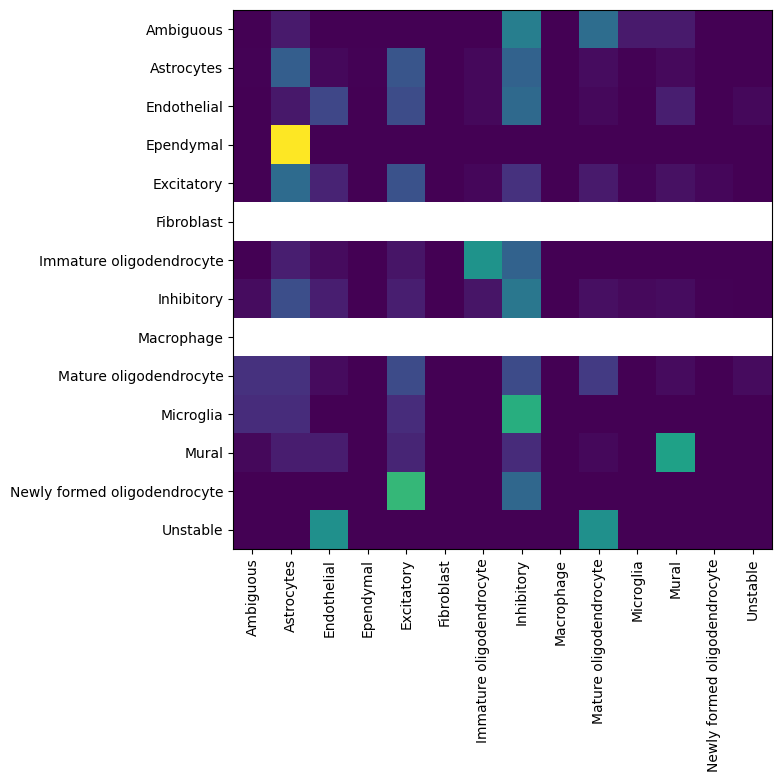

In [18]:
top_bottom_heatmap = np.zeros((len(signatures.columns),len(signatures.columns)))

for i in range(len(celltype_labels_top)):
    top_bottom_heatmap[celltype_labels_top[i],celltype_labels_bottom[i]]+=1#roi_df.divergence[i]
    top_bottom_heatmap[celltype_labels_bottom[i],celltype_labels_top[i]]+=1#roi_df.divergence[i]

top_bottom_heatmap/=top_bottom_heatmap.sum(axis=1,keepdims=True)

plt.figure(figsize=(7,7))
plt.imshow(top_bottom_heatmap)
plt.xticks(range(len(signatures.columns)),signatures.columns,rotation=90)
plt.yticks(range(len(signatures.columns)),signatures.columns)

''

In [19]:
combined_celltype_labels = []

for i in range(len(celltype_labels_top)):
    ct_str = '-'.join(sorted([signatures.columns[celltype_labels_top[i]],signatures.columns[celltype_labels_bottom[i]]]))
    combined_celltype_labels.append(ct_str)

print(combined_celltype_labels)


['Inhibitory-Mature oligodendrocyte', 'Astrocytes-Astrocytes', 'Excitatory-Mature oligodendrocyte', 'Inhibitory-Mural', 'Astrocytes-Inhibitory', 'Endothelial-Inhibitory', 'Inhibitory-Mature oligodendrocyte', 'Astrocytes-Excitatory', 'Endothelial-Mural', 'Mural-Mural', 'Inhibitory-Microglia', 'Inhibitory-Mural', 'Inhibitory-Mature oligodendrocyte', 'Astrocytes-Inhibitory', 'Astrocytes-Inhibitory', 'Astrocytes-Excitatory', 'Endothelial-Inhibitory', 'Endothelial-Endothelial', 'Astrocytes-Inhibitory', 'Endothelial-Inhibitory', 'Excitatory-Excitatory', 'Astrocytes-Immature oligodendrocyte', 'Endothelial-Excitatory', 'Astrocytes-Excitatory', 'Astrocytes-Excitatory', 'Excitatory-Mature oligodendrocyte', 'Inhibitory-Inhibitory', 'Astrocytes-Mature oligodendrocyte', 'Astrocytes-Endothelial', 'Endothelial-Excitatory', 'Inhibitory-Inhibitory', 'Excitatory-Immature oligodendrocyte', 'Mural-Mural', 'Astrocytes-Inhibitory', 'Inhibitory-Mural', 'Astrocytes-Mature oligodendrocyte', 'Astrocytes-Inhibit

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Plotting case 101


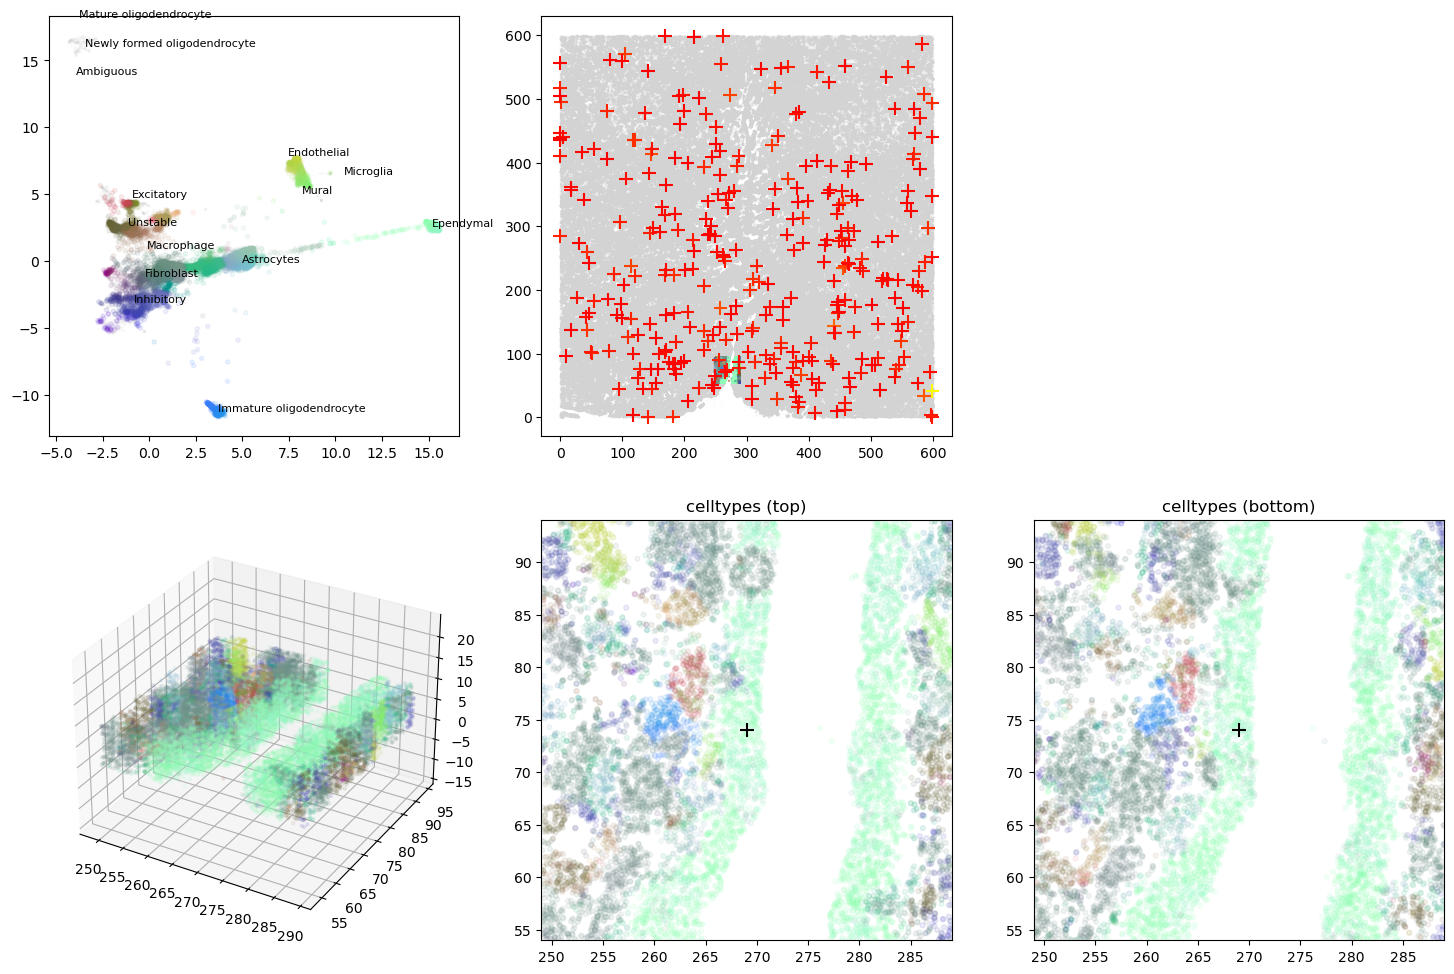

In [25]:
ependymal_cases = [i for i,l in enumerate(combined_celltype_labels)  if 'Ependymal' in l ]
astrocyte_cases = [i for i,l in enumerate(combined_celltype_labels)  if 'Astrocytes' in l ]
combined_cases = set(ependymal_cases).intersection(astrocyte_cases)

ovrlp.visualize_rois(spot_df_raw,roi_df, signature_matrix=signatures,
                     celltyping_min_expression=5,KDE_bandwidth=1.1,
                     n_cases=combined_cases,plot_window_size=20)

# plt.scatter(roi_df.x,roi_df.y,c='k')

(250.0, 290.0)

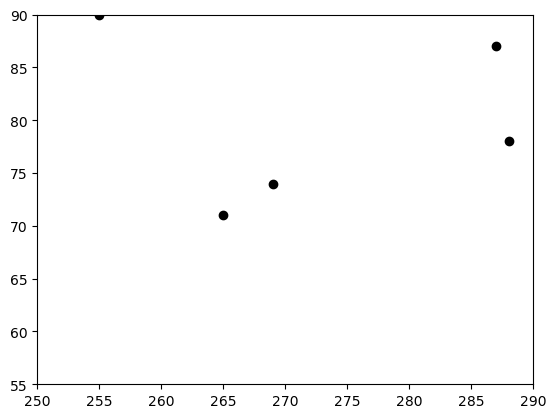

In [21]:
plt.scatter(roi_df.x,roi_df.y,c='k')
plt.ylim(55,90)
plt.xlim(250,290)

In [22]:
combinations,inverse,counts = np.unique(combined_celltype_labels,return_counts=True,return_inverse=True)

''

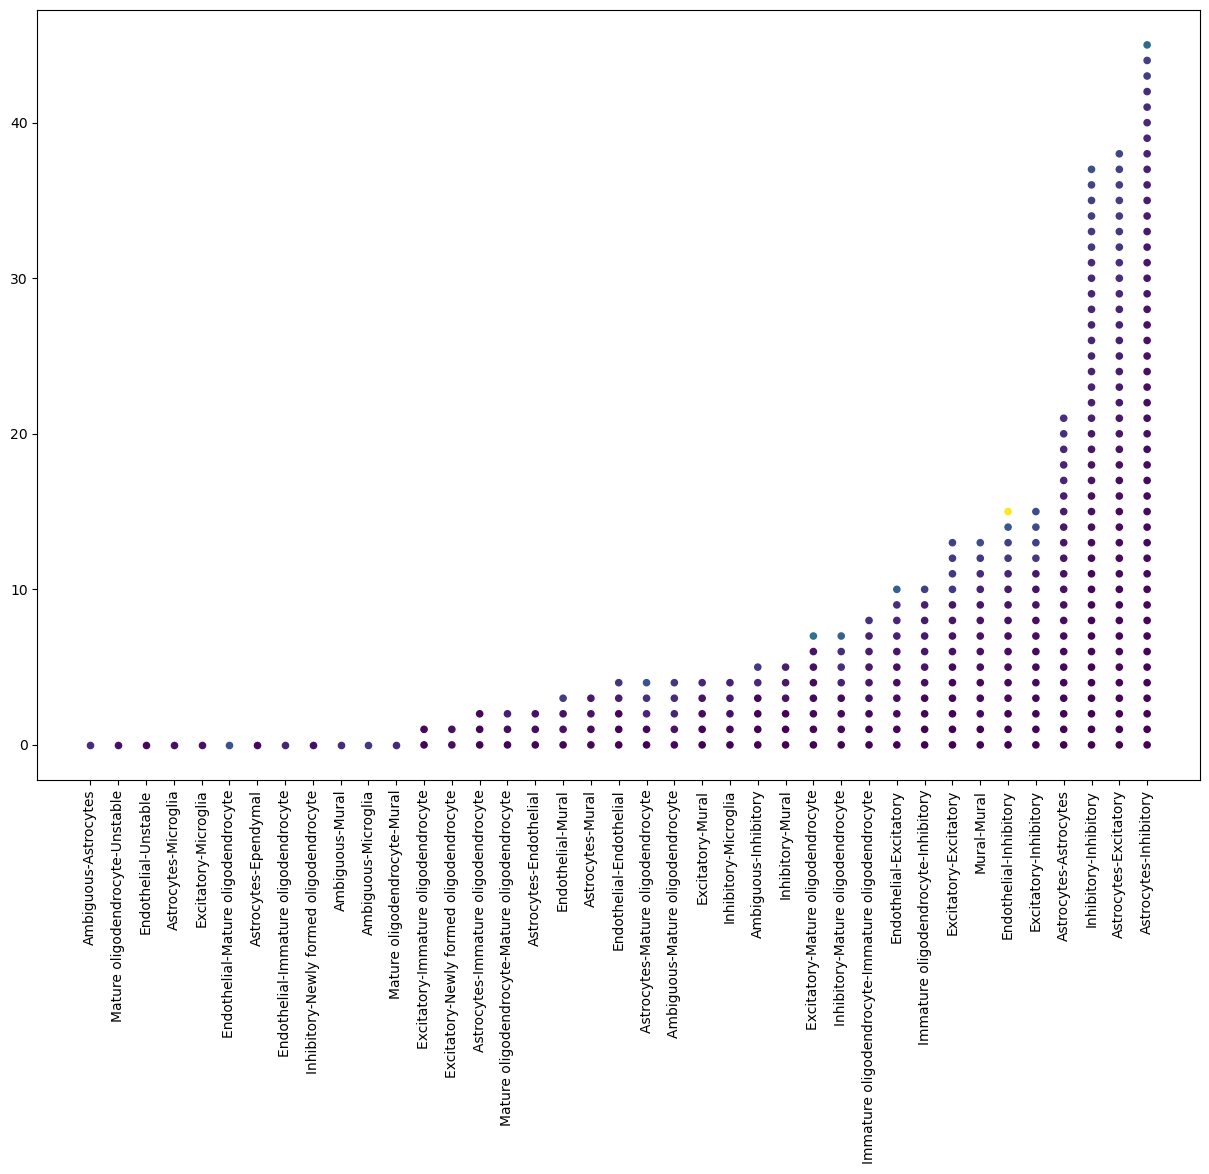

In [23]:
graphs = [[] for i in range(len(counts))]


for i in range(len(roi_df)):
    graphs[inverse[i]].append((roi_df.divergence[i]-roi_df.divergence.min())/(roi_df.divergence.max()-roi_df.divergence.min()))
                                                            
for i in range(len(counts)):
    graphs[i] = sorted(graphs[i])

graphs_idcs = np.argsort([len(l) for l in graphs])

plt.figure(figsize=(15,10))

for i in range(len(counts)):
    plt.scatter(np.ones(len(graphs[graphs_idcs[i]]))*i,
                np.arange(len(graphs[graphs_idcs[i]])),c=graphs[graphs_idcs[i]],cmap='viridis',s=20,
                vmin=0,vmax=1)

plt.xticks(np.arange(len(counts)),combinations[graphs_idcs],rotation=90)
''